# Research Question 2

Is it possible to predict the success of future instalments of a movie/game?\
Does the failure of an initial movie/game indicate commercial failures of subsequent ones? Can a franchise recover from a flop?


In [2]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt

In [3]:
pd.set_option("display.max_columns", None)

In [4]:
df = pd.read_csv("franchises_combined_by_year.csv", index_col = 0)

In [5]:
df = df.groupby('franchise_id').agg(min_year=('year', 'min'), max_year=('year', 'max')) \
       .reset_index() \
       .merge(df, on='franchise_id', how='right') \
       .assign(position_in_franchise=lambda x: (x['year'] - x['min_year']) / (x['max_year'] - x['min_year']) * 100)

In [6]:
df = df.groupby('franchise_id').agg(min_vote=('votes_average', 'min'), max_vote=('votes_average', 'max')) \
       .reset_index() \
       .merge(df, on='franchise_id', how='right')


In [7]:
df = df.groupby('franchise_id').agg(min_rating=('rating_average', 'min'), max_rating=('rating_average', 'max')) \
       .reset_index() \
       .merge(df, on='franchise_id', how='right')


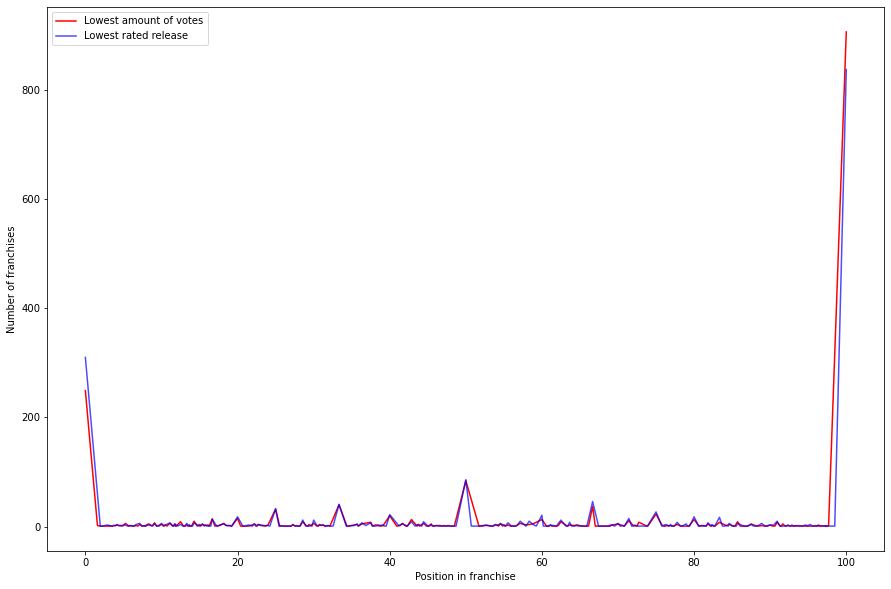

In [8]:
fig, ax = plt.subplots(figsize=(15, 10))
df[df["min_vote"] == df["votes_average"]].position_in_franchise.value_counts().sort_index().plot(xlabel="Position in franchise", ylabel="Number of franchises", color="red", ax=ax, label = "Lowest amount of votes")
df[df["min_rating"] == df["rating_average"]].position_in_franchise.value_counts().sort_index().plot(color="blue", alpha =0.7, ax=ax, label = "Lowest rated release")
plt.legend()
plt.show()

In [9]:
games_df = df[df["type"] == "game"]
movies_df = df[df["type"] == "movie"]

In [22]:
movies_df

,franchise_id,min_rating,max_rating,min_vote,max_vote,min_year,max_year,franchise_name,type,tconst,title,year,is_adult,runtime,genres,votes_average,rating_average,franchise_count,content_per_year,year_diff,vote_diff,rating_diff,num_of_releases_diff,z_rating,z_votes,position_in_franchise
7305,f0,6.00,7.7,49.0,146.0,1939,1944,The Aldrich Family,movie,tt0032123,what a life,1939,0,75,"['Drama', 'Comedy']",93.000000,6.90,11.0,1.0,NaN,NaN,NaN,NaN,0.767931,-0.330874,0.000000
7306,f0,6.00,7.7,49.0,146.0,1939,1944,The Aldrich Family,movie,tt0033834,life with henry,1940,0,80,"['Comedy', 'Music', 'Family']",49.000000,6.00,11.0,1.0,1.0,-44.000000,-0.90,0.0,-0.013058,-0.331116,20.000000
7307,f0,6.00,7.7,49.0,146.0,1939,1944,The Aldrich Family,movie,tt0033708,henry aldrich for president,1941,0,75,"['Comedy', 'Family']",146.000000,6.60,11.0,1.0,1.0,97.000000,0.60,0.0,0.507601,-0.330582,40.000000
7308,f0,6.00,7.7,49.0,146.0,1939,1944,The Aldrich Family,movie,"tt0034842, tt0034844","henry aldrich, editor, henry and dizzy",1942,0,72,"['Drama', 'Comedy', 'Family']",104.000000,6.80,11.0,2.0,1.0,-42.000000,0.20,1.0,0.681154,-0.330813,60.000000
7309,f0,6.00,7.7,49.0,146.0,1939,1944,The Aldrich Family,movie,"tt0035985, tt0035983, tt0035984","henry aldrich swings it, henry aldrich gets gl...",1943,0,64,"['Comedy', 'Adventure', 'Family']",130.333333,7.00,11.0,3.0,1.0,26.333333,0.20,1.0,0.854707,-0.330669,80.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11378,f993,6.40,7.0,99.0,658.0,1948,1952,Renato Castellani's Italian neorealism trilogy,movie,tt0040018,it's forever springtime,1950,0,92,"['Drama', 'Comedy']",99.000000,6.40,3.0,1.0,2.0,-212.000000,-0.50,0.0,0.334048,-0.330841,50.000000
11379,f993,6.40,7.0,99.0,658.0,1948,1952,Renato Castellani's Italian neorealism trilogy,movie,tt0044572,two cents worth of hope,1952,0,110,"['Romance', 'Comedy']",658.000000,7.00,3.0,1.0,2.0,559.000000,0.60,0.0,0.854707,-0.327767,100.000000
11380,f994,4.25,5.2,2068.0,5449.5,1974,1987,It's Alive,movie,"tt0071198, tt0071675","the bat people, it's alive",1974,0,93,"['Romance', 'Horror', 'Sci-Fi']",5449.500000,4.25,4.0,2.0,NaN,NaN,NaN,NaN,-1.531648,-0.301416,0.000000
11381,f994,4.25,5.2,2068.0,5449.5,1974,1987,It's Alive,movie,tt0077756,it lives again,1978,0,91,"['Horror', 'Sci-Fi']",2494.000000,5.20,4.0,1.0,4.0,-2955.500000,0.95,-1.0,-0.707271,-0.317670,30.769231


- Define a flop
- Normalise rating diff to see what the biggest drop offs are across both media
- Graph results and use it to define a reasonable threshold for a flop
- stacked bar chart for games and movies showing % of flops that "recovered"\
&nbsp; ie if the content that flopped was the last in the series\
&nbsp; (may need to filter out content that was released in the last year or 2)


In [23]:
games_df.loc[games_df.franchise_name.isin(movies_df.franchise_name),'match']=True

C:\Users\35387\AppData\Local\Temp\ipykernel_106852\3994652624.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games_df.loc[games_df.franchise_name.isin(movies_df.franchise_name),'match']=True


In [30]:
games_df[pd.notnull(games_df["match"])]["franchise_name"].unique()

array(['Commando', 'Peanuts', 'Lucky Luke', 'The Godfather', 'X-Men',
       'Pirates of the Caribbean', 'Dead or Alive', 'Cars', 'Die Hard',
       'Madagascar', 'Starship Troopers', 'The Punisher',
       'FIFA World Cup', 'Blair Witch', 'Kung Fu Panda', 'Ice Age',
       'Godzilla', 'Winnie the Pooh', 'Transformers', 'Despicable Me',
       'Tom and Jerry', 'Drift', 'Terminator', 'Alvin and the Chipmunks',
       'Star Trek', 'SpongeBob SquarePants', 'Indiana Jones', 'Shrek',
       'James Bond', 'Jaws', 'Jurassic Park', 'Rocky', 'RoboCop',
       'Resident Evil', 'Rambo', 'Jumanji', 'Back to the Future',
       'Pokémon', 'One Piece', 'The Lord of the Rings', 'Mickey Mouse',
       'Mission: Impossible', 'Star Wars', 'Spider-Man', 'Sailor Moon',
       'Evil Dead', 'Ghostbusters', 'The Matrix', 'Home Alone',
       'Mortal Kombat', 'Bleach', 'Nancy Drew', 'Blood', 'Toy Story',
       'Digimon', 'Barbie', 'The Flintstones', 'Monty Python',
       'Men in Black', 'Asterix'], dtype=ob

As discussed on Friday it will be interesting to see how you define a "flop" and explore the recovery or otherwise after a flop. try to keep it simple reasonable. If you decide, for example, that a flop is a movie/game that has x% fewer ratings/votes that the preceding title then that's fine as long as you can defend x. You can also write you analysis code in such a way as to make it easy to change x so that you can do a "sensitivity analysis" by varying x. If you find that the outcome is similar for various ranges of x then that's a good sign.
